In [1]:
import geopandas as gpd 
import pandas as pd 
import numpy as np 
import shapely
from shapely import Polygon, MultiPolygon, geometry, Point
from pyproj import CRS
from pre_processing import bd_preprocess
import warnings
from PIL import Image
from timezonefinder import TimezoneFinder
import pytz
import suncalc
from suncalc import get_times
import os
import pickle
import pybdshadow
from calendar import monthrange
from tqdm import tqdm
warnings.filterwarnings('ignore')

c:\Users\30684\conda_environment\envs\python3.8\lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\30684\AppData\Local\Temp\ipykernel_5404\2534052203.py:1: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smoo

In [14]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from functools import partial
from collections import OrderedDict
from torch.utils.data import Dataset, DataLoader
from datetime import datetime
import os
import pickle
import suncalc
import PIL
import PIL.Image
from torchvision import transforms
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split

class PatchEmbed(nn.Module):
    '''
    1D Image to Patch Embedding
    '''
    def __init__(self,img_size=1280,patch_size=20, in_c=1,embed_dim=400,norm_lay=None):
        super().__init__()
        # 图片分辨率
        img_size = (img_size, img_size)
        # 卷积核大小
        patch_size = (patch_size,patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        # 分别计算w，h方向上的patch个数
        self.grid_size = (img_size[0]//patch_size[0],img_size[1]//patch_size[1])
        # 一张图片的patch个数
        self.num_patches = self.grid_size[0]*self.grid_size[1]
        self.embed_dim = self.patch_size[0]*self.patch_size[1]*in_c
        # 卷积的步长实现图片切分操作，而后与patch大小一致的卷积核完成线性映射
        self.proj = nn.Conv2d(in_c,embed_dim,kernel_size=patch_size,stride=patch_size)
        self.norm = norm_lay(embed_dim) if norm_lay else nn.Identity()

    def forward(self,x):
        x = self.proj(x).flatten(2).transpose(1,2)
        x = self.norm(x)
        return x
    

class LayerNorm(nn.LayerNorm):
    """Subclass torch's LayerNorm to handle fp16."""

    def forward(self, x: torch.Tensor):
        orig_type = x.dtype
        ret = super().forward(x.type(torch.float32))
        return ret.type(orig_type)


class QuickGELU(nn.Module):
    def forward(self, x: torch.Tensor):
        return x * torch.sigmoid(1.702 * x)
    
class ResidualAttentionBlock(nn.Module):
    def __init__(self, d_model: int, n_head: int):
        super().__init__()

        self.attn = nn.MultiheadAttention(d_model, n_head)
        self.ln_1 = LayerNorm(d_model)
        self.mlp = nn.Sequential(OrderedDict([
            ("c_fc", nn.Linear(d_model, d_model * 4)),
            ("gelu", QuickGELU()),
            ("c_proj", nn.Linear(d_model * 4, d_model))
        ]))
        self.ln_2 = LayerNorm(d_model)

    def attention(self, x: torch.Tensor):
        return self.attn(x, x, x, need_weights=False)[0]

    def forward(self, x: torch.Tensor):
        x = x + self.attention(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x
class Transformer(nn.Module):
    def __init__(self, width: int, layers: int, heads: int):
        super().__init__()
        self.width = width
        self.layers = layers
        self.resblocks = nn.Sequential(*[ResidualAttentionBlock(width, heads) for _ in range(layers)])

    def forward(self, x: torch.Tensor):
        return self.resblocks(x)
    

class Angle_Encoder(nn.Module):
    def __init__(self, angle_length, emb_dim, dropout_rate=0.1):
        super(Angle_Encoder,self).__init__()
        self.emb_dim = emb_dim
        self.lr = nn.Linear(angle_length,emb_dim)
        self.pos_embedding = nn.Parameter(torch.zeros(1,4096,emb_dim))
        self.transformer = Transformer(emb_dim,8,8)
        if dropout_rate>0:
            self.dropout = nn.Dropout(dropout_rate)
        else:
            self.dropout = None
    def forward(self, x):
        out = self.lr(x)
        out = out.unsqueeze(1)
        out = out.repeat((1,4096,1))
        out = out + self.pos_embedding
        out = self.transformer(out)
        if self.dropout:
            out = self.dropout(out)
        return out  

class PositionEmbs(nn.Module):
    def __init__(self, angle_length, num_patches, emb_dim, dropout_rate=0.1):
        super(PositionEmbs,self).__init__()
        self.angle_encoder = Angle_Encoder(angle_length, emb_dim,dropout_rate)
        self.pos_embedding = nn.Parameter(torch.zeros(1,num_patches,emb_dim))
        if dropout_rate >0:
            self.dropout = nn.Dropout(dropout_rate)
        else:
            self.dropout = None
    def forward(self,x, angle):
        out = x+self.pos_embedding + self.angle_encoder(angle)
        if self.dropout:
            out = self.dropout(out)
        return out
    

class Attention(nn.Module):
    def __init__(self,
                 dim,   # 输入token的dim
                 num_heads=8,
                 qkv_bias=False,
                 qk_scale=None,
                 attn_drop_ratio=0.,
                 proj_drop_ratio=0.):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop_ratio)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop_ratio)

    def forward(self, x):
        # [batch_size, num_patches + 1, total_embed_dim]
        B, N, C = x.shape

        # qkv(): -> [batch_size, num_patches + 1, 3 * total_embed_dim]
        # reshape: -> [batch_size, num_patches + 1, 3, num_heads, embed_dim_per_head]
        # permute: -> [3, batch_size, num_heads, num_patches + 1, embed_dim_per_head]
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        # [batch_size, num_heads, num_patches + 1, embed_dim_per_head]
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        # transpose: -> [batch_size, num_heads, embed_dim_per_head, num_patches + 1]
        # @: multiply -> [batch_size, num_heads, num_patches + 1, num_patches + 1]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        # @: multiply -> [batch_size, num_heads, num_patches + 1, embed_dim_per_head]
        # transpose: -> [batch_size, num_patches + 1, num_heads, embed_dim_per_head]
        # reshape: -> [batch_size, num_patches + 1, total_embed_dim]
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x
    
class Mlp(nn.Module):
    """
    MLP as used in Vision Transformer, MLP-Mixer and related networks
    """
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

def drop_path(x, drop_prob: float = 0., training: bool = False):
    """
    Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).
    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.
    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # (shape[0],1,1,1)
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)   # rand范围在[0~1]之间, +keep_prob在[keep_prob~keep_prob+1]之间
    random_tensor.floor_()  # 只保留0或者1
    output = x.div(keep_prob) * random_tensor   # x.div(keep_prob)个人理解是为了强化保留部分的x
    return output


class DropPath(nn.Module):
    """
    Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)
    
class Block(nn.Module):
    def __init__(self,
                 dim,
                 num_heads,
                 mlp_ratio=4.,
                 qkv_bias=False,
                 qk_scale=None,
                 drop_ratio=0.,
                 attn_drop_ratio=0.,
                 drop_path_ratio=0.,
                 act_layer=nn.GELU,
                 norm_layer=nn.LayerNorm):
        super(Block, self).__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
                              attn_drop_ratio=attn_drop_ratio, proj_drop_ratio=drop_ratio)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path_ratio) if drop_path_ratio > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop_ratio)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))   
        x = x + self.drop_path(self.mlp(self.norm2(x)))   
        return x
    
class VisionTransformer(nn.Module):
    def __init__(self, angle_length = 2, img_size=1280, patch_size=20, in_c=1, 
                 embed_dim=400, depth=12, num_heads=8, mlp_ratio=4.0, qkv_bias=True,
                 qk_scale=None, representation_size=None, distilled=False, drop_ratio=0.,
                 attn_drop_ratio=0., drop_path_ratio=0., embed_layer=PatchEmbed, norm_layer=None,
                 act_layer=None):
        """
        Args:
            img_size (int, tuple): input image size
            patch_size (int, tuple): patch size
            in_c (int): number of input channels
            embed_dim (int): embedding dimension
            depth (int): depth of transformer
            num_heads (int): number of attention heads
            mlp_ratio (int): ratio of mlp hidden dim to embedding dim
            qkv_bias (bool): enable bias for qkv if True
            qk_scale (float): override default qk scale of head_dim ** -0.5 if set
            representation_size (Optional[int]): enable and set representation layer (pre-logits) to this value if set
            distilled (bool): model includes a distillation token and head as in DeiT models
            drop_ratio (float): dropout rate
            attn_drop_ratio (float): attention dropout rate
            drop_path_ratio (float): stochastic depth rate
            embed_layer (nn.Module): patch embedding layer
            norm_layer: (nn.Module): normalization layer
        """
        super(VisionTransformer,self).__init__()
        # embed_dim默认tansformer的base 256
        self.num_features = self.embed_dim = embed_dim
        # 源码distilled是为了其他任务,分类暂时不考虑
        self.num_tokens = 2 if distilled else 1
        # LayerNorm:对每单个batch进行的归一化
        norm_layer = norm_layer or partial(nn.LayerNorm,eps=1e-6)
        # act_layer默认tansformer的GELU
        act_layer = act_layer or nn.GELU
        # embed_layer默认是patch embedding,在其他应用中应该会有其他选择
        # patch embedding过程
        self.patch_embed = embed_layer(img_size=img_size, patch_size=patch_size, in_c=in_c, embed_dim=embed_dim)
        # patche个数
        num_patches = self.patch_embed.num_patches
        # positional embedding过程
        self.pos_embedding = PositionEmbs(angle_length, num_patches, embed_dim, drop_ratio)
        # depth是Block的个数
        # 不同block层数 drop_ratio的概率不同,越深度越高
        dpr = [x.item() for x in torch.linspace(0, drop_path_ratio, depth)]  # stochastic depth decay rule
        # blocks搭建
        self.blocks = nn.Sequential(*[
            Block(dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                  drop_ratio=drop_ratio, attn_drop_ratio=attn_drop_ratio, drop_path_ratio=dpr[i],
                  norm_layer=norm_layer, act_layer=act_layer)
            for i in range(depth)
        ])

        self.norm = norm_layer(embed_dim)
        
    def forward_features(self,x, angle):
        x = self.patch_embed(x)
        x = self.pos_embedding(x, angle)
        x = self.blocks(x)
        x = self.norm(x)
        return x
    
    def forward(self,x, angle):
        x = self.forward_features(x, angle)
        return x

In [3]:
def generate_grid(bds_aeqd, accuracy):
    lon_start = bds_aeqd.bounds['minx'].min()
    lon_end = bds_aeqd.bounds['maxx'].max()
    lat_start = bds_aeqd.bounds['miny'].min()
    lat_end = bds_aeqd.bounds['maxy'].max()
    # 创建x和y的坐标网格
    x = np.arange(lon_start, lon_end+accuracy, accuracy)  # 因为间隔是-1，所以步长是-1
    y = np.arange(lat_start, lat_end+accuracy, accuracy)
    # 使用meshgrid生成网格
    X, Y = np.meshgrid(x, y)
    grid_list = []
    grid_dict = {}
    for i in range(X.shape[0]-1):
        for j in range(X.shape[1]-1):
            poly1 = Polygon([(X[i][j],Y[i][j]),(X[i][j+1],Y[i][j+1]),(X[i+1][j+1],Y[i+1][j+1]),(X[i+1][j],Y[i+1][j])])
            # 将多边形添加到 GeoDataFrame 中，并设置索引
            grid_list.append(
                {'geometry': poly1, 'grid_id': str(i)+','+str(j)}
            )
            grid_dict[str(i)+','+str(j)] = poly1
    # 使用列表一次性创建 GeoDataFrame
    grid_gdf = gpd.GeoDataFrame(grid_list, crs=bds_aeqd.crs)
    shape = (X.shape[0]-1, X.shape[1]-1)
    return grid_gdf, grid_list, shape

def get_timetable(lon, lat, dates=['2022-06-07'], precision=3600, padding=1800):
    # generate timetable with given interval
    def get_timeSeries(day, lon, lat, precision=3600, padding=1800):
        date = pd.to_datetime(day+' 12:45:33.959797119')
        times = get_times(date, lon, lat)
        date_sunrise = times['sunrise'].value
        date_sunset = times['sunset'].value
        times = pd.to_datetime(pd.Series(range(
            date_sunrise+padding*1000000000,
            date_sunset-padding*1000000000,
            precision*1000000000)))
        return times
    dates = pd.DataFrame(pd.concat(
        [get_timeSeries(date, lon, lat, precision, padding) for date in dates]), columns=['datetime'])
    dates['date'] = dates['datetime'].apply(lambda r: str(r)[:19])
    return dates

In [4]:
def generate_feature(grid, bds_aeqd, shape,column):
    grid_gdf = grid.copy()
    feature = np.zeros((shape[0],shape[1]))
    grid_gdf['centroid'] = grid_gdf['geometry'].apply(lambda gemo: Point(gemo.centroid))
    feature_grid = grid_gdf.copy()
    feature_grid.rename(columns={'geometry':'geometry_1','centroid':'geometry'},inplace=True)
    sjoin = gpd.sjoin(feature_grid,bds_aeqd)
    sjoin.sort_values(by=['grid_id',column],ascending=False,inplace=True)
    sjoin.drop_duplicates(subset=['grid_id'],keep='first',inplace=True)
    for _,row in sjoin.iterrows():
        str_index = row['grid_id']
        x = int(str_index.split(',')[0])
        y = int(str_index.split(',')[1])
        feature[x][y] = row[column]
    sjoin.rename(columns={'geometry':'geometry_2'},inplace=True)
    sjoin.rename(columns={'geometry_1':'geometry'},inplace=True)
    sjoin = gpd.GeoDataFrame(sjoin,geometry='geometry')
    sjoin.crs=bds_aeqd.crs
    return feature, sjoin


In [5]:
def get_bd_feature(bds, accuracy):
    bds = pybdshadow.bd_preprocess(bds)
    center_lon, center_lat =bds.geometry.centroid.x.mean() ,bds.geometry.centroid.y.mean()
    epsg = CRS(f"+proj=aeqd +lat_0={center_lat} +lon_0={center_lon} +datum=WGS84")
    bds_aeqd = bds.to_crs(epsg)
    accuracy = 2
    grid_gdf, grid_list, shape = generate_grid(bds_aeqd, accuracy)
    # 产生特征数据
    feature, feature_gdf = generate_feature(grid_gdf,bds_aeqd,shape,'height')
    return feature, feature_gdf, grid_gdf, bds_aeqd, center_lon, center_lat, epsg, shape

def get_bd_timetable(center_lon, center_lat, dates=None):
    # 开始生成相应的栅格阴影
    tf = TimezoneFinder()
    timezone_str = tf.timezone_at(lng=center_lon, lat=center_lat)
    timezone = pytz.timezone(timezone_str)
    time_table = get_timetable(center_lon,center_lat)
    if dates != None:
        time_table = get_timetable(center_lon,center_lat,dates)
    ## 转换成本地时间
    time_table['date'] = pd.to_datetime(time_table['date'])
    time_table['local_date'] = time_table['date'].dt.tz_localize('UTC').dt.tz_convert(timezone)
    return time_table

def calcluate_shadows(bds, date_time,epsg):
    shadows = pybdshadow.bdshadow_sunlight(bds,date_time,roof=True,include_building = False)
    shadows['shadow'] = 1
    shadows = gpd.GeoDataFrame(shadows,geometry='geometry')
    shadows = shadows.set_crs(bds.crs)
    shadows_aeqd = shadows.to_crs(epsg)
    return shadows, shadows_aeqd

def generate_shadow_grid(grid_gdf, shadows_aeqd, shape):
    y, y_gdf = generate_feature(grid_gdf,shadows_aeqd,shape,'shadow')
    return y, y_gdf

In [6]:
bds = gpd.read_file(r'.\buildings\香港_high_500_simplify.geojson')
## 生成格子特征
feature, feature_gdf, grid_gdf, bds_aeqd, center_lon, center_lat, epsg, shape = get_bd_feature(bds,accuracy=2)
## 生成时间
time_table = get_bd_timetable(center_lon,center_lat)
## 获取想要的时间段
date_time = time_table.iloc[0]['datetime']
## 生成时间段的阴影情况
shadows, shadows_aeqd = calcluate_shadows(bds,date_time,epsg)
## 生成阴影格子
y, y_gdf = generate_shadow_grid(grid_gdf,shadows_aeqd, shape)

In [15]:
def get_pred_y(model, date_time, feature, device,w1,w2,h1,h2):
    feature_pad = F.pad(torch.Tensor(feature),(int(pad_w/2),pad_w-int(pad_w/2),int(pad_h/2),pad_h-int(pad_h/2)))
    sun_position = suncalc.get_position(date_time,center_lon,center_lat)
    sun_alt = sun_position['altitude']
    sun_azi = sun_position['azimuth']
    position = [sun_alt,sun_azi]
    position = np.array(position)
    position = torch.Tensor(position)
    feature_pad = feature_pad.unsqueeze(0)
    position = position
    feature_pad = feature_pad.to(device)
    position = position.to(device)
    pred = model(feature_pad.unsqueeze(0),position.unsqueeze(0))
    return pred

In [16]:
import torch
import torch.nn.functional as F
import suncalc
## 加载模型预测
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load('./model_unless.pth')
pad_h = 1280- feature.shape[0]
pad_w = 1280 - feature.shape[1]
w1 = int(pad_w/2)
w2 = pad_w-int(pad_w/2)
h1 = int(pad_h/2)
h2 = pad_h-int(pad_h/2)
pred = get_pred_y(model,date_time,feature,device,w1,w2,h1,h2)

In [19]:
def calcluate_position(row, pred,w1,w2,h1,h2):
    grid_id = row['grid_id']
    x, y =int(grid_id.split(',')[0]), int(grid_id.split(',')[1])
    return float(pred[x+h1,y+w1])

<AxesSubplot:>

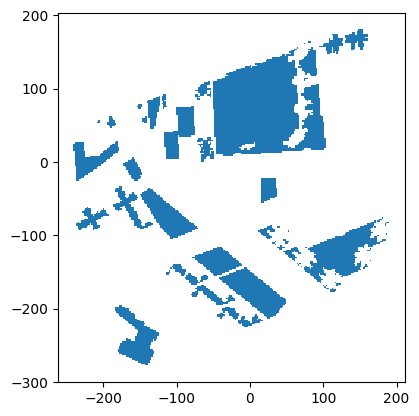

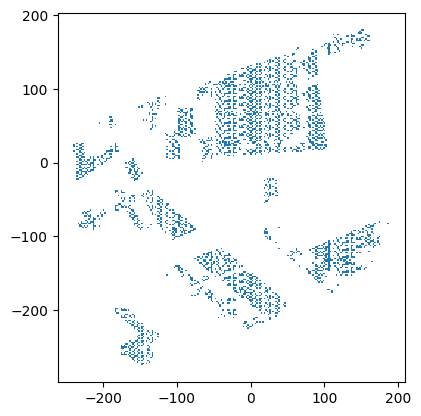

In [29]:
pred = pred.reshape(1280,1280)
y_gdf_roof = y_gdf[y_gdf['type']=='roof']
y_gdf_roof['pred_shadow'] = y_gdf_roof.apply(lambda x: calcluate_position(x,pred,w1,w2,h1,h2),axis=1)
y_gdf_roof.plot()
y_gdf_roof[y_gdf_roof['pred_shadow']>0.5].plot()

## 可视化阴影分布情况

In [35]:
## 可视化阴影分布情况
def show(shadows_aeqd,bds_aeqd):
    import matplotlib.pyplot as plt
    fig = plt.figure(1, (12, 12))
    ax = plt.subplot(111)
    # plot buildings
    bds_aeqd.plot(ax=ax)
    # plot shadows
    # shadows_roof = shadows[shadows['type']=='roof']
    shadows_aeqd.plot(ax=ax, alpha=0.7,
                column='type',
                categorical=True,
                cmap='Set1_r',
                legend=True)

    plt.show()

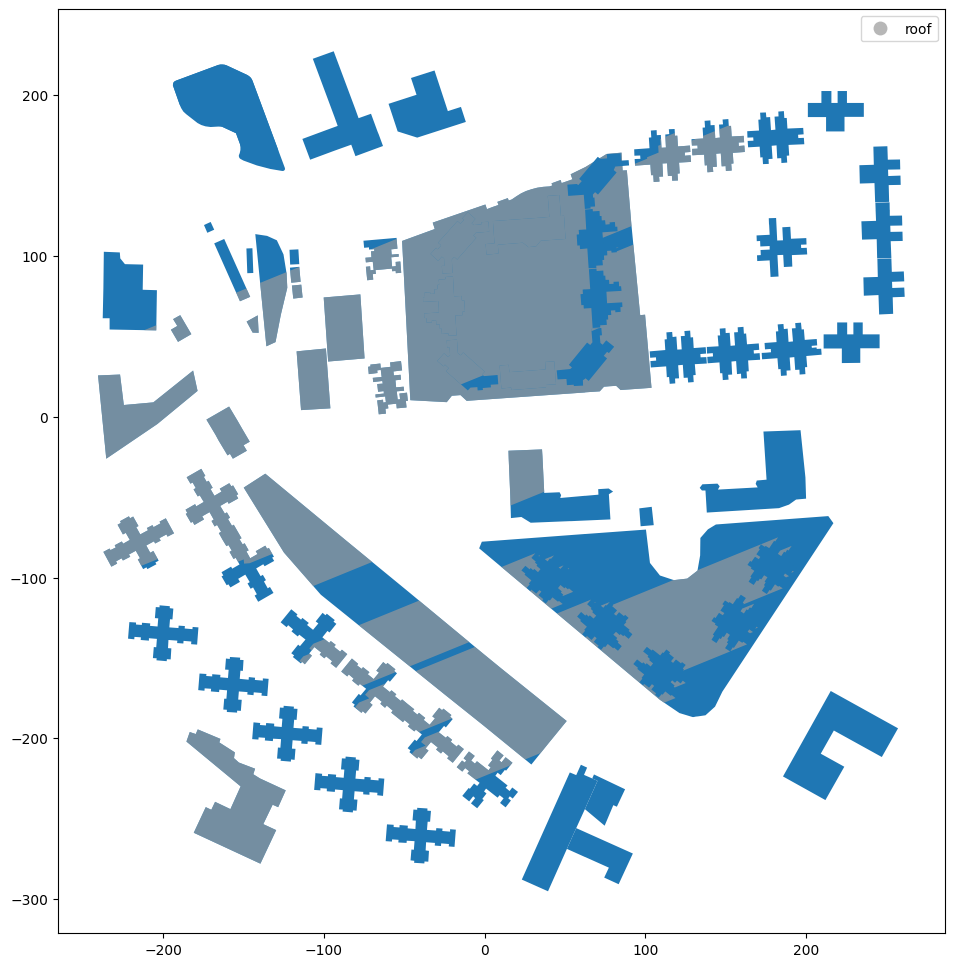

In [37]:
show(shadows_aeqd[shadows_aeqd['type']=='roof'], bds_aeqd)

In [40]:
def show_heatmap(data,mask):
    import matplotlib.pyplot as plt 
    plt.imshow(data*mask,cmap='hot')
    plt.colorbar()
    plt.show()

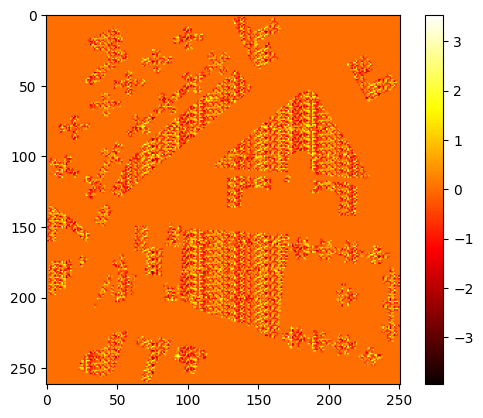

In [50]:
mask = (torch.Tensor(feature) != 0).float()
pred_unpad_y = pred[h1:h1+feature.shape[0],w1:w1+feature.shape[1]].to('cpu')
show_heatmap(torch.Tensor(pred_unpad_y.detach().numpy()),mask)

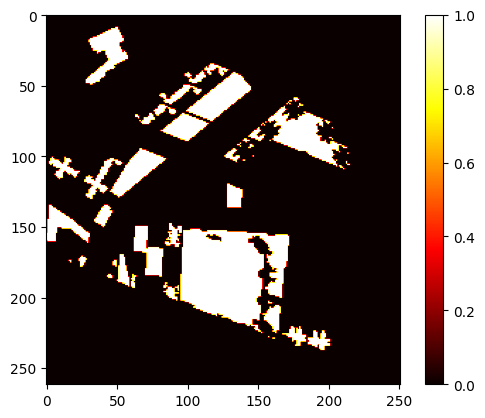

In [52]:
show_heatmap(torch.Tensor(y),mask)